In [1]:
%load_ext autoreload
%autoreload 2
#%matplotlib notebook

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

In [3]:
theme = ''
directory = 'C:/Users/gueux/source/repos/gencon/x64/Debug/'
directory = 'C:/Users/gueux/patchV1/'
if theme:
    theme = theme + '_'
pos_file = f'{directory}{theme}V1_pos.bin'
conMat_file = f'{directory}{theme}V1_conMat.bin'
delayMat_file = f'{directory}{theme}V1_delayMat.bin'
vec_file = f'{directory}{theme}V1_vec.bin'
blkPos_file = f'{directory}{theme}block_pos.bin'
nabaBlk_file = f'{directory}{theme}neighborBlock.bin'
stats_file = f'{directory}{theme}conStats.bin'
feature_file = f'{directory}{theme}V1_feature.bin'

In [4]:
with open(pos_file, 'r') as f:
    nblock = np.fromfile(f, 'u4', count=1)[0]
    blockSize = np.fromfile(f, 'u4', count=1)[0]
    dataDim = np.fromfile(f, 'u4', count=1)[0]
    pos = np.reshape(np.fromfile(f, 'f8'), (nblock,2,blockSize))
networkSize = nblock*blockSize

In [5]:
# read block center pos
with open(blkPos_file, 'rb') as f:
    blkPos = np.reshape(np.fromfile(f, 'f4', count = 2*nblock), (2,nblock))
# read block neighbor id
with open(nabaBlk_file,'rb') as f:
    nNabaBlk = np.fromfile(f, 'u4', count = nblock)
    nabaBlkId = np.empty(nblock,dtype=object)
    print(nNabaBlk)
    for i in range(nblock):
        nabaBlkId[i] = np.fromfile(f, 'u4', count = nNabaBlk[i])            
        print(nabaBlkId[i])

[5 7 9 9 7 6 8 9 9 8 6 6 9 8 7 8 9 6 6 8 7 7 7 7 8 6 4 6 6 6 6 4]
[0 2 3 4 1]
[1 2 5 6 0 7 3]
[2 1 3 0 7 6 8 5 4]
[ 3  4  2  0  8  9  7 10  1]
[ 4  3 10  9  0  8  2]
[ 5  6 11  1 12  2]
[ 6  5  7 12 13  2  1 11]
[ 7  6  8  2 13 14  3 12  1]
[ 8  9  7  3 15 14  2 16  4]
[ 9 10  8 16 15  3  4 17]
[10  9 17  4 16  3]
[11 12 18  5 19  6]
[12 11 13 19  6 20  5 18  7]
[13 12 14 20  7 21  6 19]
[14 15 13 22 21  8  7]
[15 16 14 23  8 22  9 24]
[16 17 15 24  9 23 10 25  8]
[17 16 25 10 24  9]
[18 19 26 11 12 27]
[19 18 20 27 12 26 11 13]
[20 19 27 21 13 28 12]
[21 28 20 22 14 13 29]
[22 29 23 21 14 15 28]
[23 24 30 22 15 29 16]
[24 25 23 30 16 31 17 15]
[25 24 31 17 16 30]
[26 18 19 27]
[27 19 20 26 28 18]
[28 21 20 27 22 29]
[29 22 23 30 21 28]
[30 24 23 31 29 25]
[31 25 24 30]


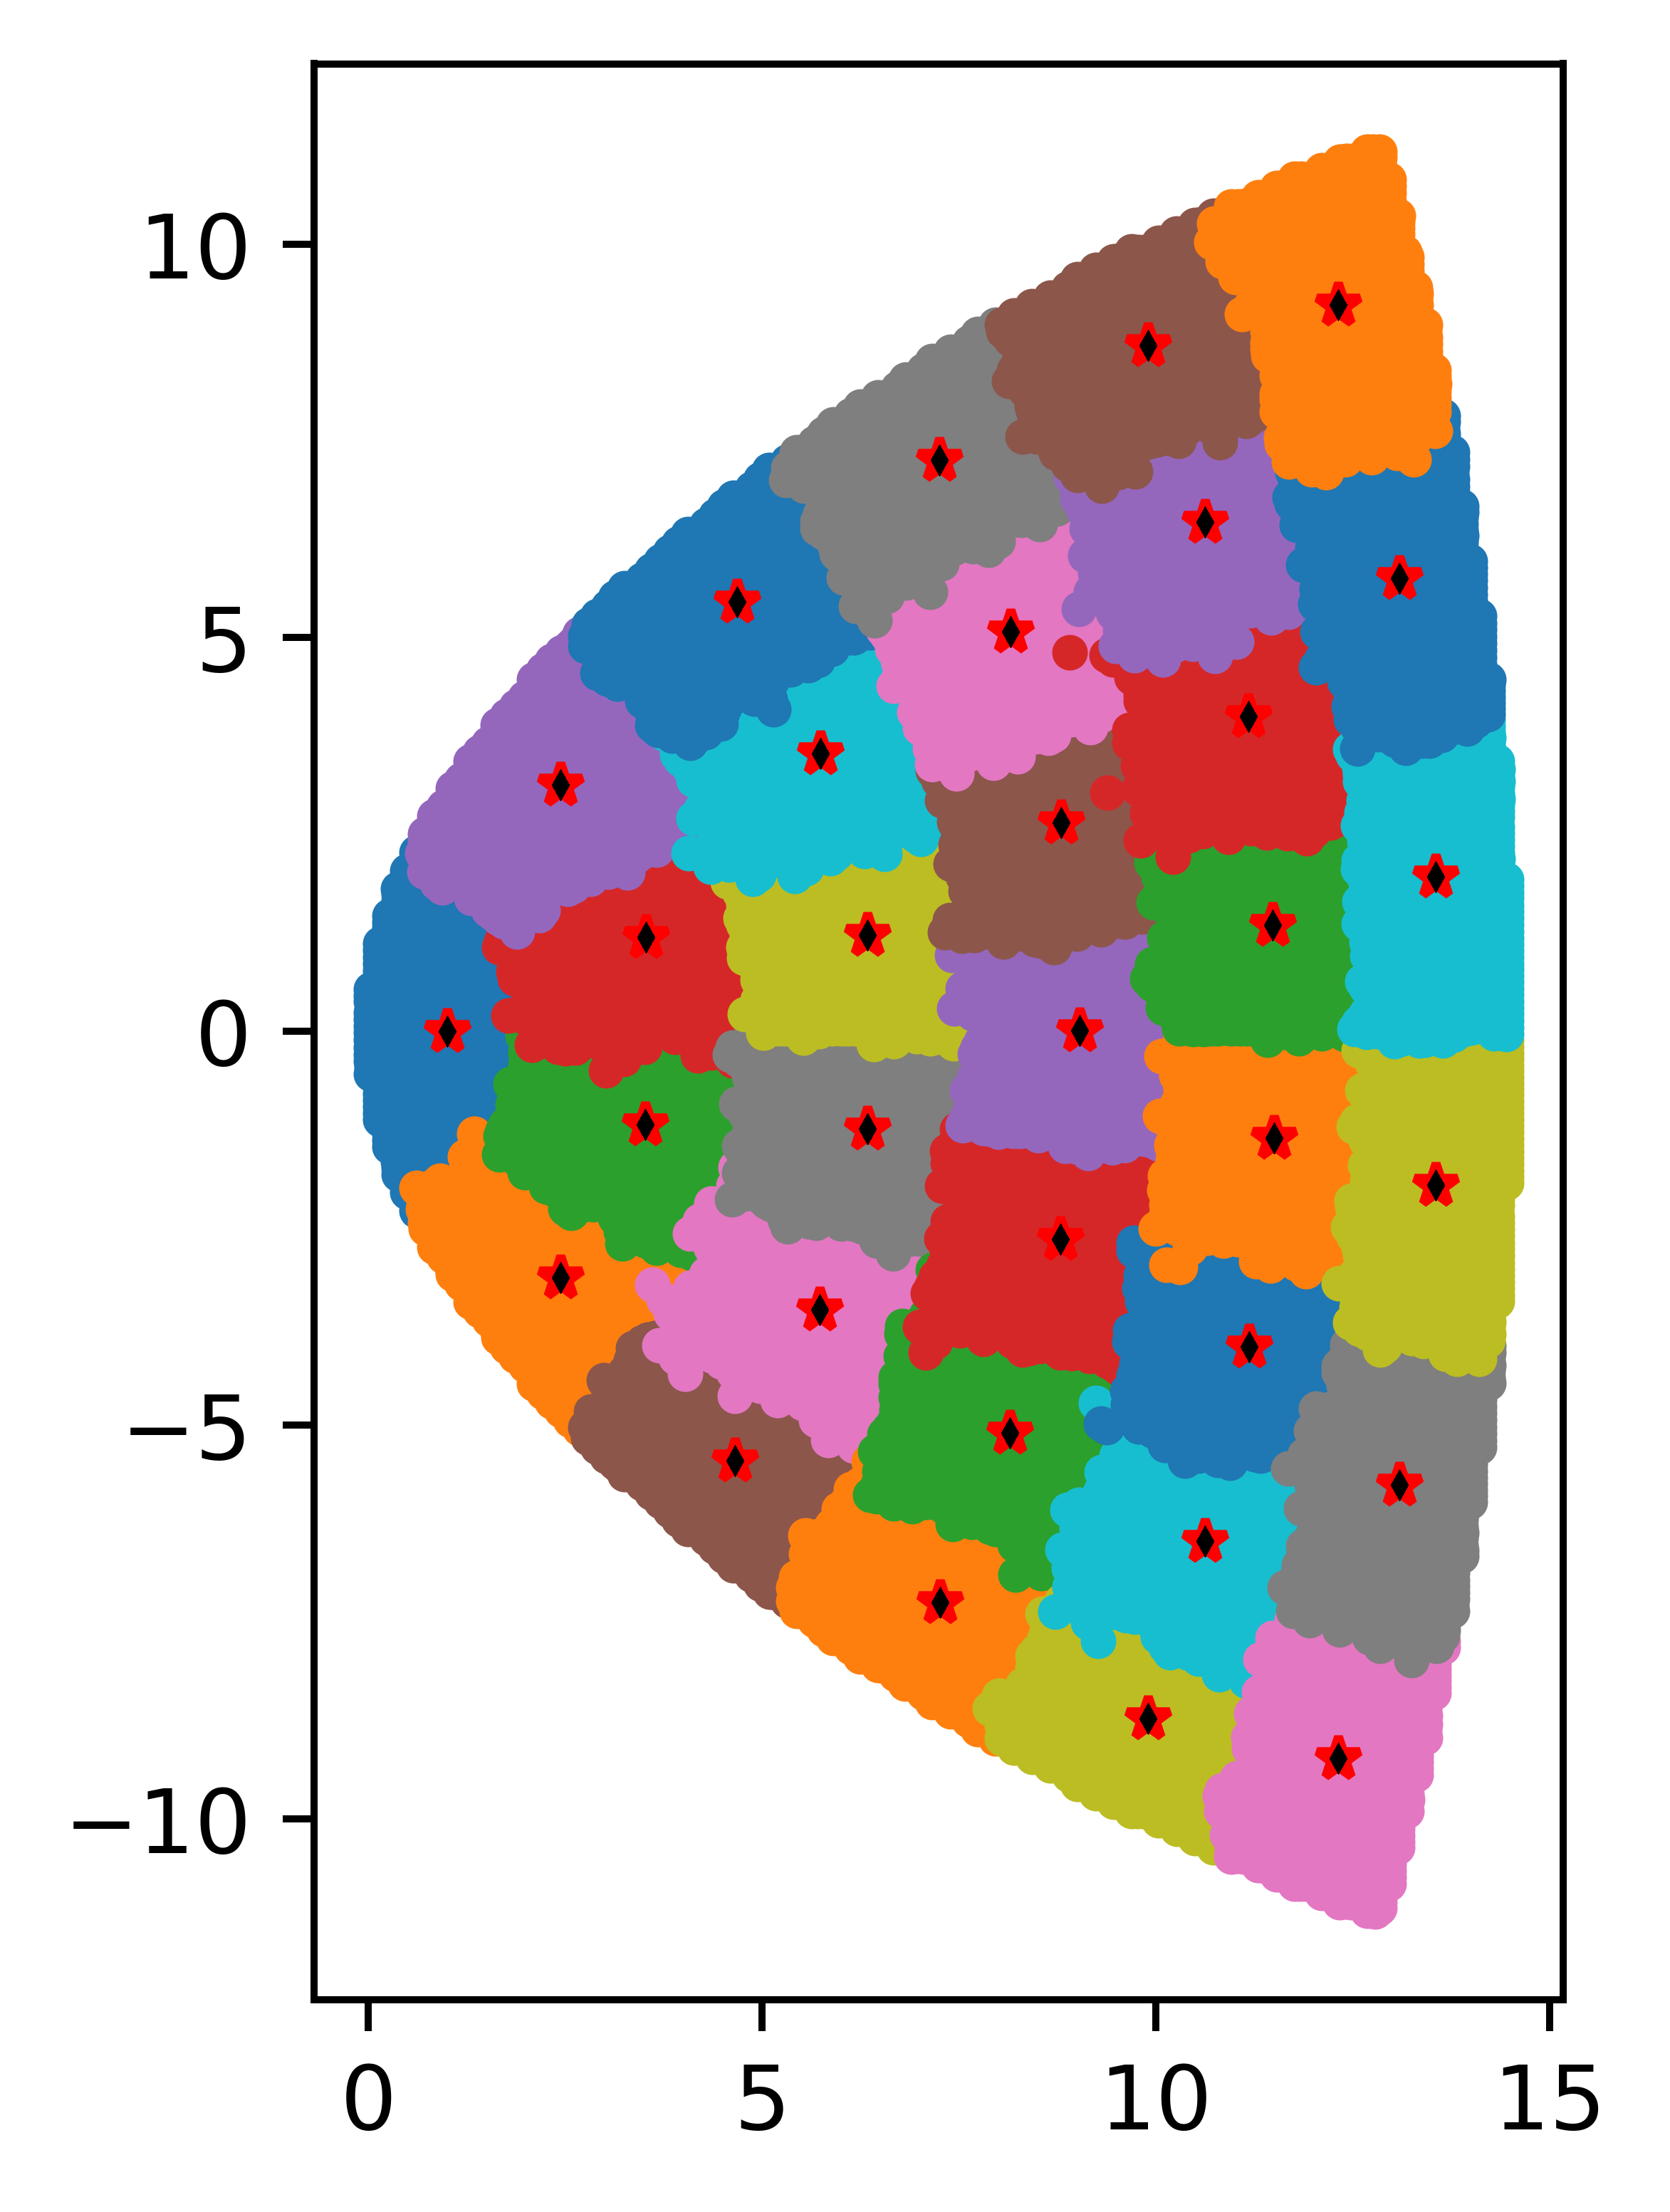

In [6]:
fig = plt.figure('pos', dpi = 900)
ax = fig.add_subplot(111)
for i in range(nblock):
    plt.plot(pos[i,0,:], pos[i,1,:], '.')
    plt.plot(blkPos[0,i], blkPos[1,i], '*r', ms = 5)
for i in range(nblock):
    for j in range(nNabaBlk[i]):
        plt.plot(blkPos[0,nabaBlkId[i]], blkPos[1,nabaBlkId[i]], 'dk', ms = 1)
ax.set_aspect('equal')

In [12]:
with open(conMat_file, 'rb') as f:
    nearNeighborBlock = np.fromfile(f, 'u4', count=1)[0]
    conMat = np.reshape(np.fromfile(f, 'f4', count = networkSize*nearNeighborBlock*blockSize),(nblock, nearNeighborBlock, blockSize, blockSize)) # pre, post
    print(f'connection strength (only for connected pairs), min, mean, max: {np.min(conMat[conMat>0])}, {np.mean(conMat[conMat>0])}, {np.max(conMat[conMat>0])}')
    print(f'connection strength (include all pairs), mean:{np.mean(conMat)}')
with open(delayMat_file, 'rb') as f:
    nearNeighborBlock = np.fromfile(f, 'u4', count=1)[0]
    delayMat = np.reshape(np.fromfile(f, 'f4', count = networkSize*nearNeighborBlock*blockSize),(nblock, nearNeighborBlock, blockSize, blockSize)) # pre, post
    print(f'delays: {np.min(delayMat)}, {np.mean(delayMat)}, {np.max(delayMat)} ms')
    
with open(vec_file, 'rb') as f:
    nVec = np.fromfile(f, 'u4', count = networkSize)
    vecID = np.empty(networkSize, dtype=object)
    conVec = np.empty(networkSize, dtype=object)
    delayVec = np.empty(networkSize, dtype=object)
    for i in range(networkSize):
        if nVec[i] > 0:
            vecID[i] = np.fromfile(f, 'u4', count = nVec[i])
            conVec[i] = np.fromfile(f, 'f4', count = nVec[i])
            delayVec[i] = np.fromfile(f, 'f4', count = nVec[i])
        else:
            vecID[i] = np.array([])
            conVec[i] = np.array([])
            delayVec[i] = np.array([])
print(f'number of connections outside block: {np.min(nVec)}, {np.mean(nVec)}, {np.max(nVec)}')
with open(feature_file, 'rb') as f:
    nFeature = np.fromfile(f, 'u4', count = 1)[0]
    LR = np.fromfile(f,'f4', count = networkSize)
print(nearNeighborBlock)

connection strength (only for connected pairs), min, mean, max: 1.0, 1.7448779344558716, 16.9039306640625
connection strength (include all pairs), mean:0.060006752610206604
delays: 0.0, 1.065305233001709, 3.499999761581421 ms
number of connections outside block: 0, 0.0, 0
9


In [10]:
print(np.sum(conMat[0,0,:,:]==0))
print(conMat[0,0,:,:].size)

908019
1048576


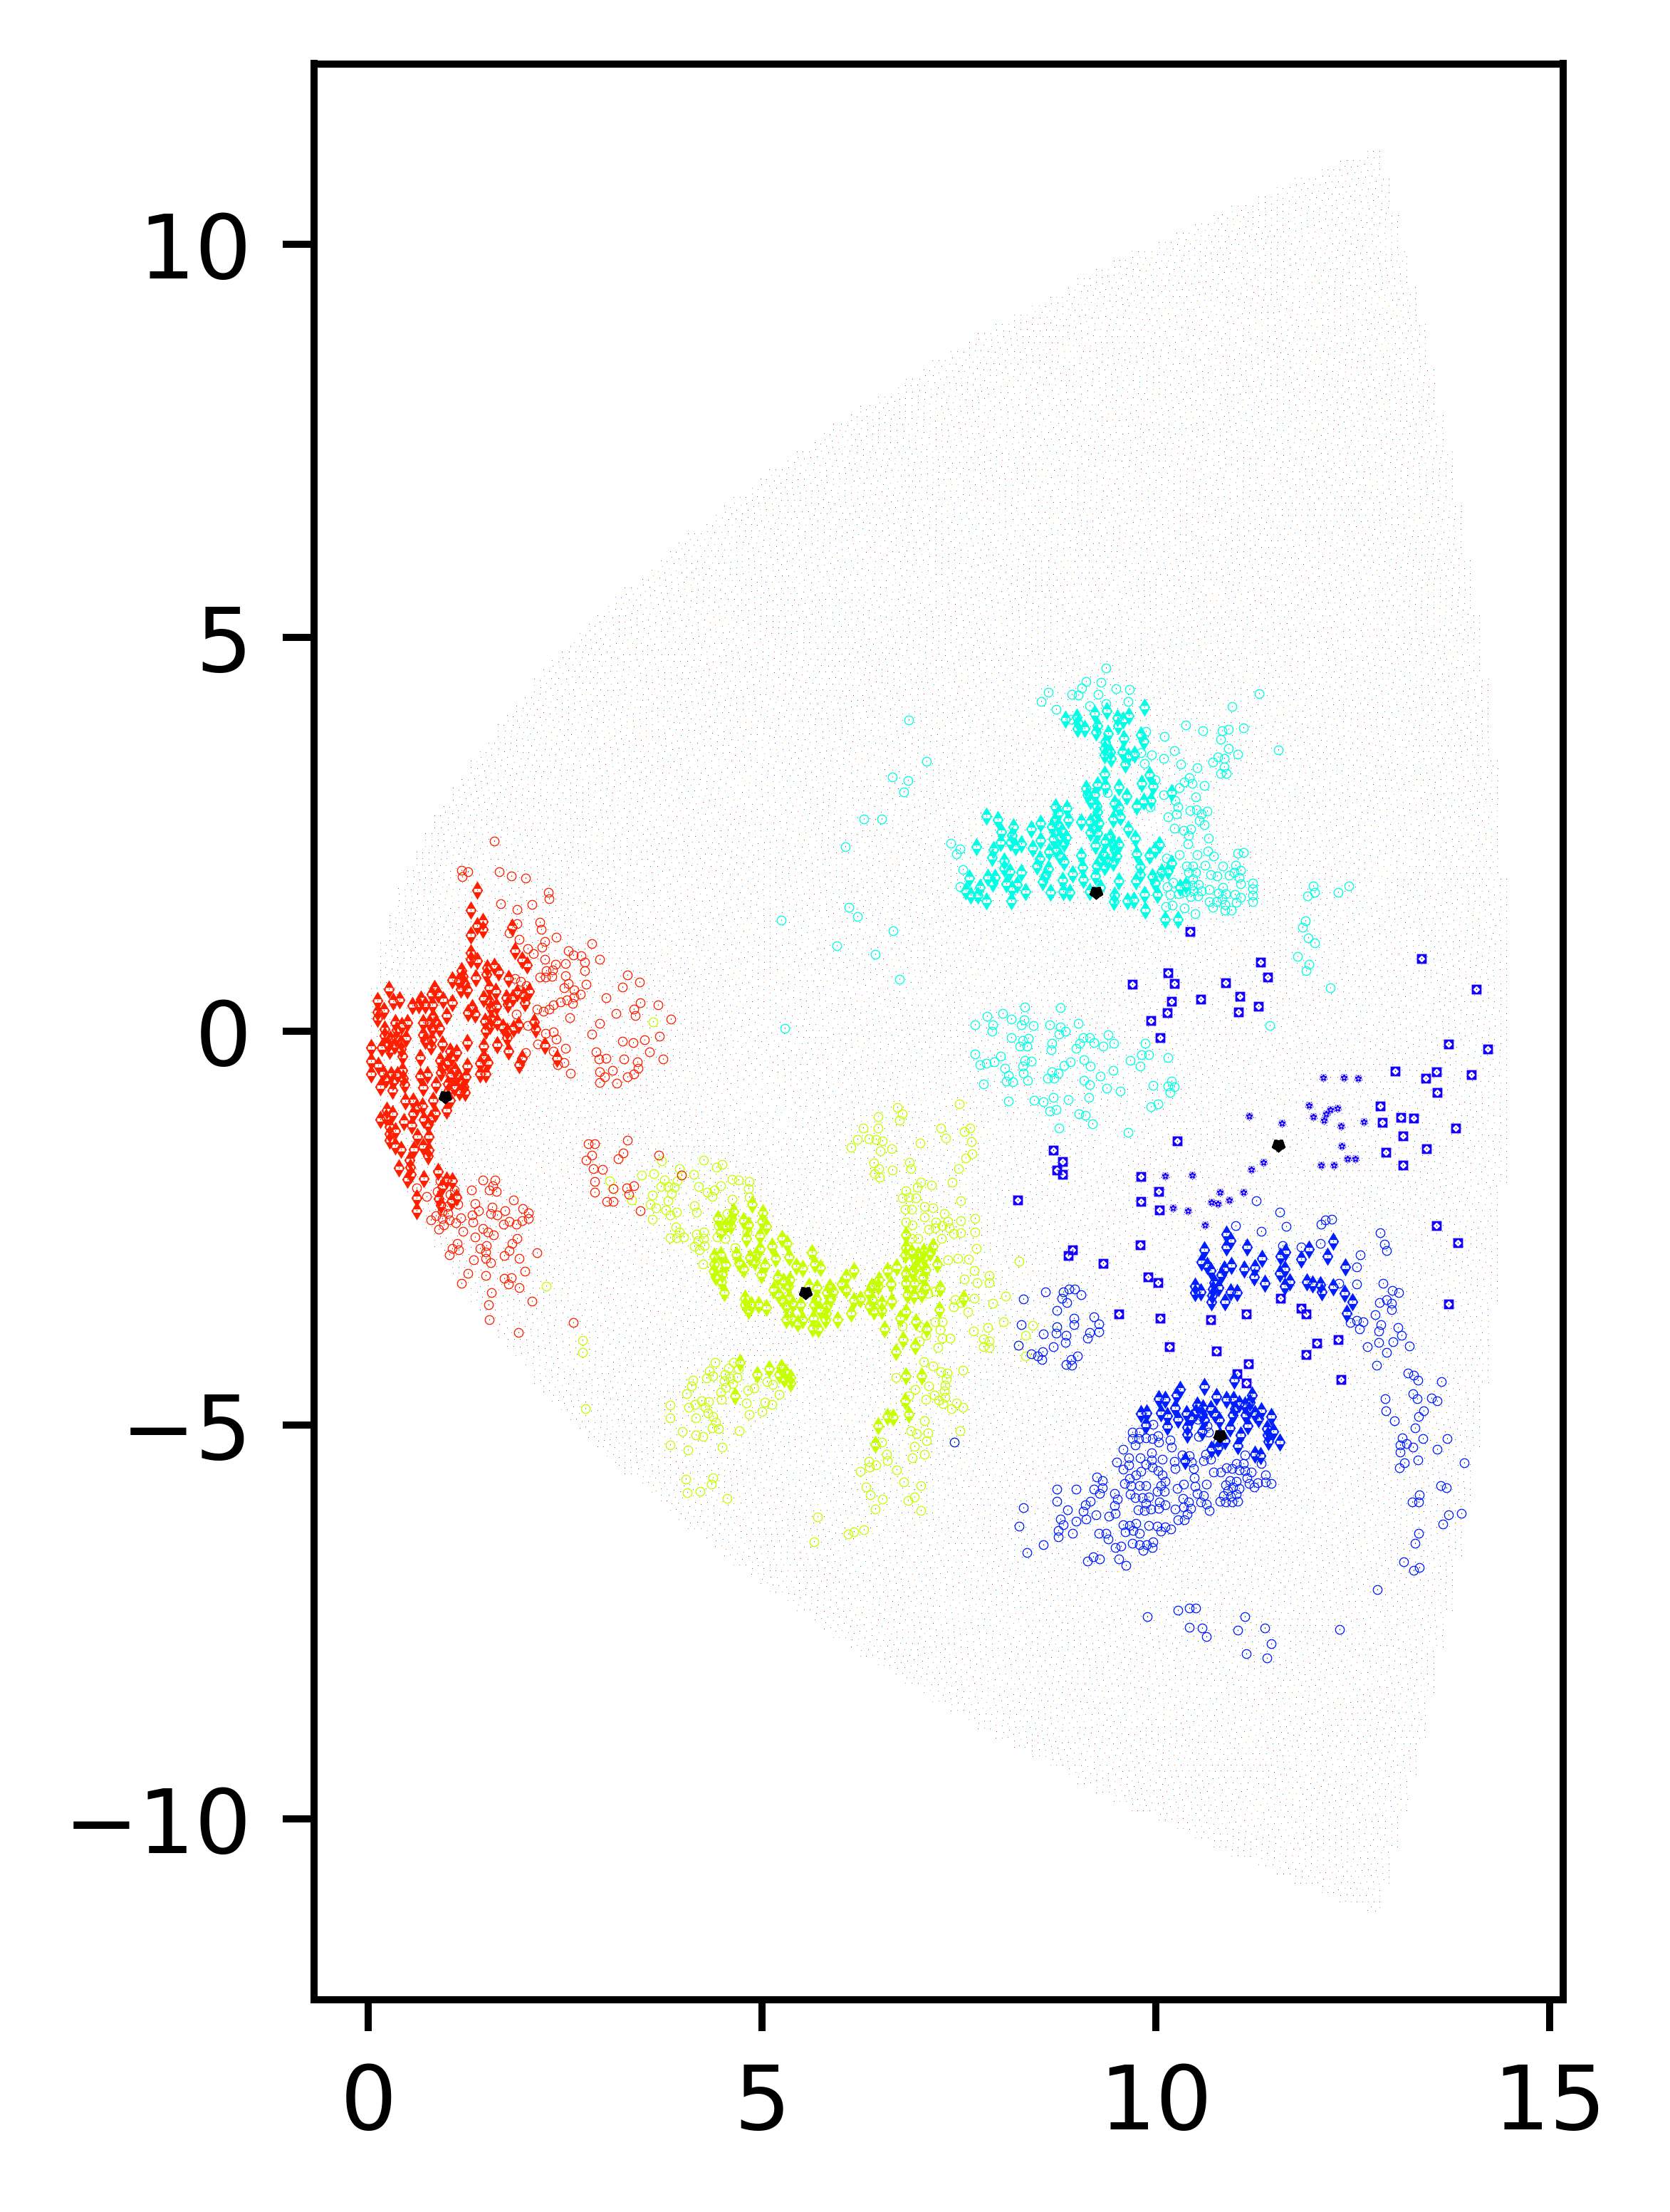

In [9]:
fig = plt.figure('con', dpi = 900)
ax = fig.add_subplot(111)
ax.plot(pos[:,0,:], pos[:,1,:], ',')
np.random.seed(912143)
example = np.random.randint(0,networkSize,(5,))
for i in example:
    color = mpl.colors.hsv_to_rgb([i/networkSize, 1, 1])
    # post
    bid = i//blockSize
    tid = i-blockSize*bid
    # pre within the blocks nearby
    #for j in range(nearNeighborBlock):
    for j in range(nNabaBlk[bid]):
        jbid = nabaBlkId[bid][j]
        #color = mpl.colors.hsv_to_rgb([j/nearNeighborBlock, 1, 1])
        #left
        if j == 0:
            marker = '*'
        else:
            marker = 's'
        mat_pick = np.logical_and(conMat[bid,j,:,tid]>0, LR[jbid*blockSize:(jbid+1)*blockSize]<0)
        #print(np.sum(mat_pick == True))
        ax.plot(pos[jbid,0,mat_pick], pos[jbid,1,mat_pick], marker, c=color, ms = 0.1)
        #right
        if j == 0:
            marker = 'd'
        else:
            marker = 'o'
        mat_pick = np.logical_and(conMat[bid,j,:,tid]>0, LR[jbid*blockSize:(jbid+1)*blockSize]>0)
        #print(np.sum(mat_pick == True))
        ax.plot(pos[jbid,0,mat_pick], pos[jbid,1,mat_pick], marker, c=color, ms = 0.1)
        
    if nVec[i] > 0:
        # pre outside the block
        L_pick = LR[nVec[i]] < 0
        vbid = vecID[i][L_pick]//blockSize
        vtid = vecID[i][L_pick] - blockSize*vbid
        ax.plot(pos[vbid,0,vtid], pos[vbid,1,vtid], '<', c=color, ms = 0.1)
        R_pick = LR[nVec[i]] > 0
        vbid = vecID[i][R_pick]//blockSize
        vtid = vecID[i][R_pick] - blockSize*vbid
        ax.plot(pos[vbid,0,vtid], pos[vbid,1,vtid], '>', c=color, ms = 0.1)
    ax.plot(pos[bid,0,tid], pos[bid,1,tid],'*k', ms = 1)
ax.set_aspect('equal')

In [12]:
with open(stats_file, 'rb') as f:
    nType = np.fromfile(f, 'u4', count=1)[0]
    networkSize = np.fromfile(f, 'u4', count=1)[0]
    connected = np.reshape(np.fromfile(f, 'u4', count=nType*networkSize), (nType, networkSize))
    avail = np.reshape(np.fromfile(f, 'u4', count=nType*networkSize), (nType, networkSize))
    strength = np.reshape(np.fromfile(f, 'f4', count=nType*networkSize), (nType, networkSize))

In [29]:
print(np.sum(avail,axis=-1))
print(np.sum(connected,axis=-1))

[109104795  36024235]
[3346308 7052118]


(array([  10.,   17.,   28.,   33.,   39.,   50.,   52.,   57.,   77.,
          72.,   84.,   91.,  125.,  157.,  218.,  309.,  517.,  714.,
         719.,  727.,  716.,  702.,  741.,  729.,  762.,  750.,  800.,
         822.,  807.,  787.,  885.,  838.,  726.,  657.,  657.,  417.,
         536.,  588.,  740.,  864., 1022., 1227., 1356., 1514., 1630.,
        1795., 1790., 1764., 1402.,  648.]),
 array([1333.  , 1422.46, 1511.92, 1601.38, 1690.84, 1780.3 , 1869.76,
        1959.22, 2048.68, 2138.14, 2227.6 , 2317.06, 2406.52, 2495.98,
        2585.44, 2674.9 , 2764.36, 2853.82, 2943.28, 3032.74, 3122.2 ,
        3211.66, 3301.12, 3390.58, 3480.04, 3569.5 , 3658.96, 3748.42,
        3837.88, 3927.34, 4016.8 , 4106.26, 4195.72, 4285.18, 4374.64,
        4464.1 , 4553.56, 4643.02, 4732.48, 4821.94, 4911.4 , 5000.86,
        5090.32, 5179.78, 5269.24, 5358.7 , 5448.16, 5537.62, 5627.08,
        5716.54, 5806.  ]),
 <a list of 50 Patch objects>)

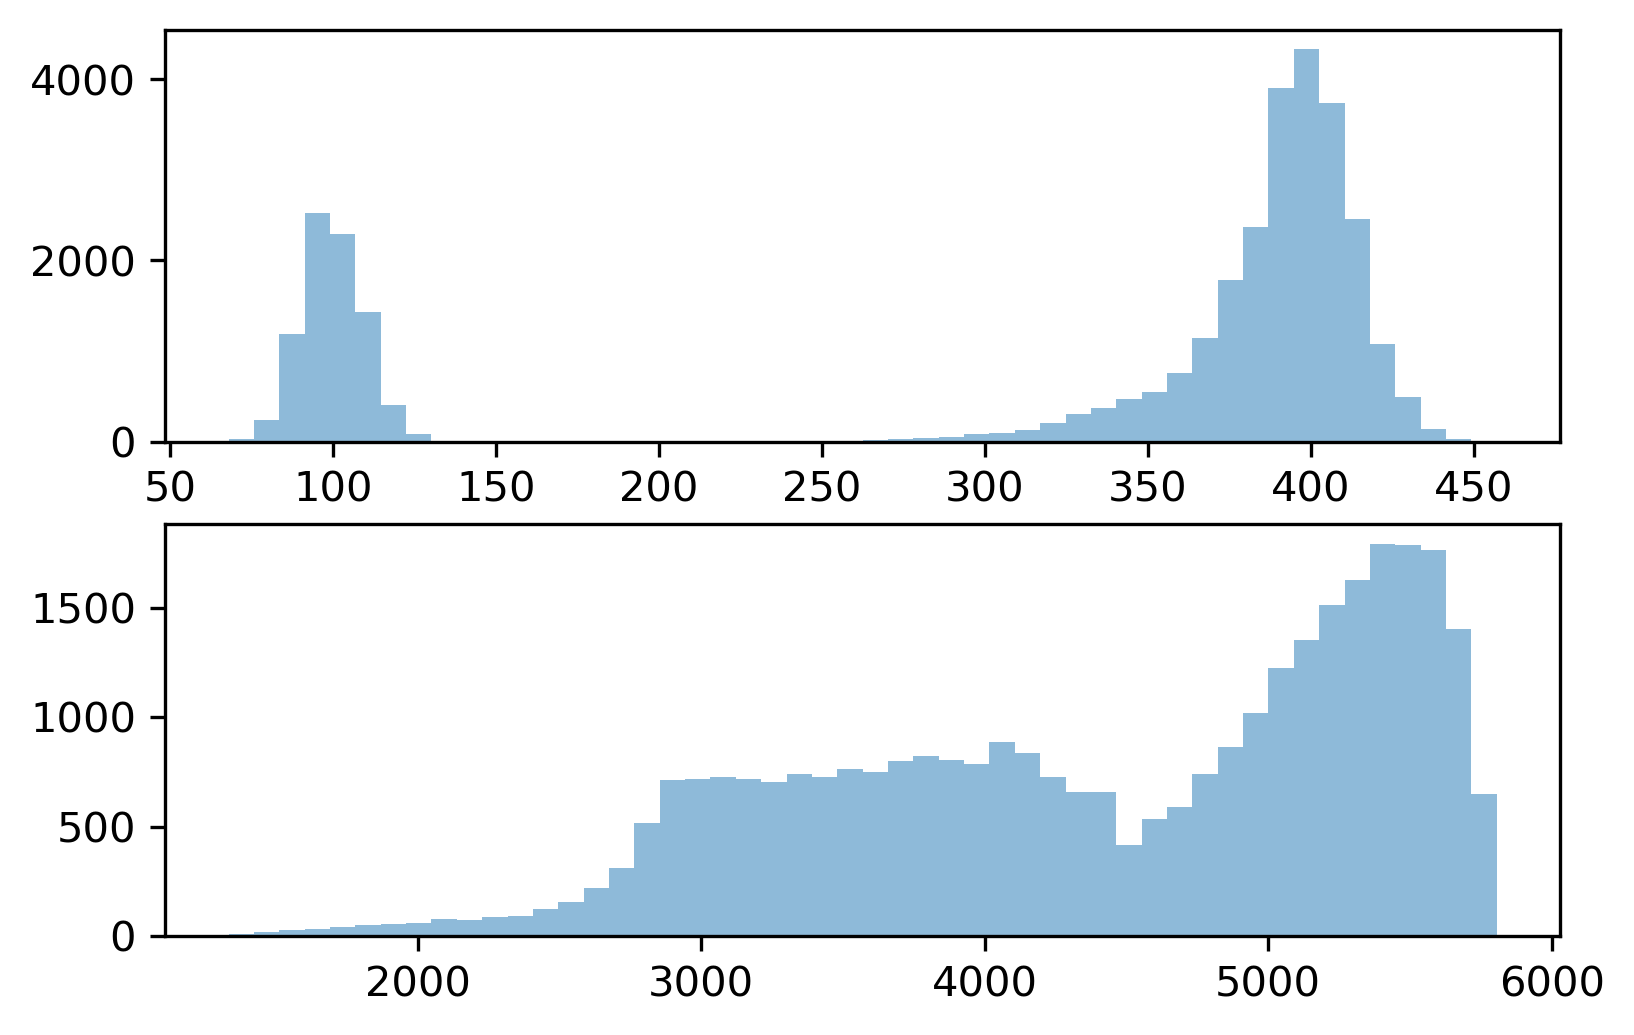

In [30]:
fig = plt.figure('stats', dpi = 300)
ax = fig.add_subplot(211)
ax.hist(np.sum(connected.T,axis=-1), bins = 50, alpha = 0.5)
ax = fig.add_subplot(212)
ax.hist(np.sum(avail.T,axis=-1), bins = 50, alpha = 0.5)
#ax.hist(strength.T, bins = 10)

0 0.04617020123820566 0.023825093739380573
1 0.25484268407832694 0.10189389478810659


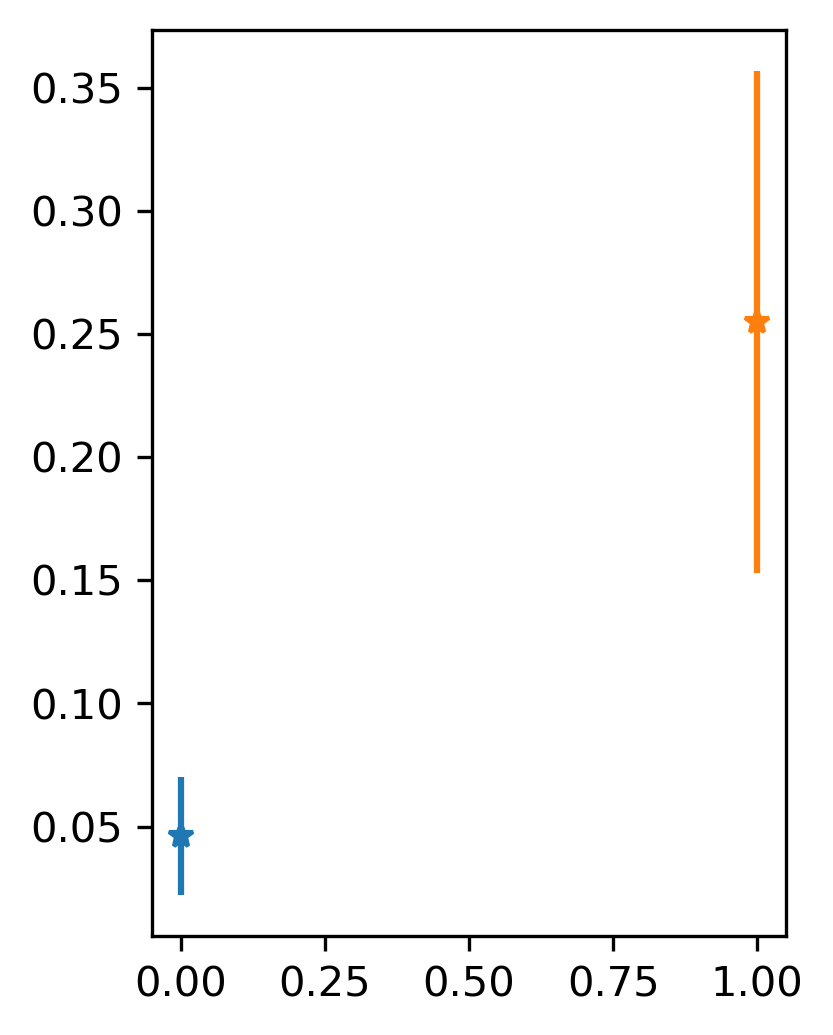

In [18]:
fig = plt.figure('stats', dpi = 300)
ax = fig.add_subplot(121)
target = np.empty(avail.shape)
for i in range(nType):
    pick = avail[i,:] != 0
    assert((connected[i,np.logical_not(pick)] == 0).all())
    target[i,pick] = connected[i,pick]/avail[i,pick]
    mt = np.average(target[i,pick])
    st = np.std(target[i,pick])
    print(i, mt, st)
    ax.errorbar(i, mt, st, marker='*')
    #target = strength/connected
    #ax.errorbar(i+0.5, np.average(target), np.std(target))

In [179]:
mindis = np.float('inf')
meandis = 0
for i in range(1,nblock):
    p2 = np.power(blkPos - np.roll(blkPos,i,1),2)
    dis = np.sqrt(np.sum(p2,0))
    mind = np.min(dis)
    meandis = meandis + np.sum(dis)
    if mindis > mind:
        mindis = mind
print(meandis/2/(nblock*(nblock-1)))
print(mindis)

3.994896673387097
2.146566


In [164]:
a = np.arange(0,10).reshape(2,5)

In [174]:
np.roll(a,1,1)

array([[4, 0, 1, 2, 3],
       [9, 5, 6, 7, 8]])

(0, 1)

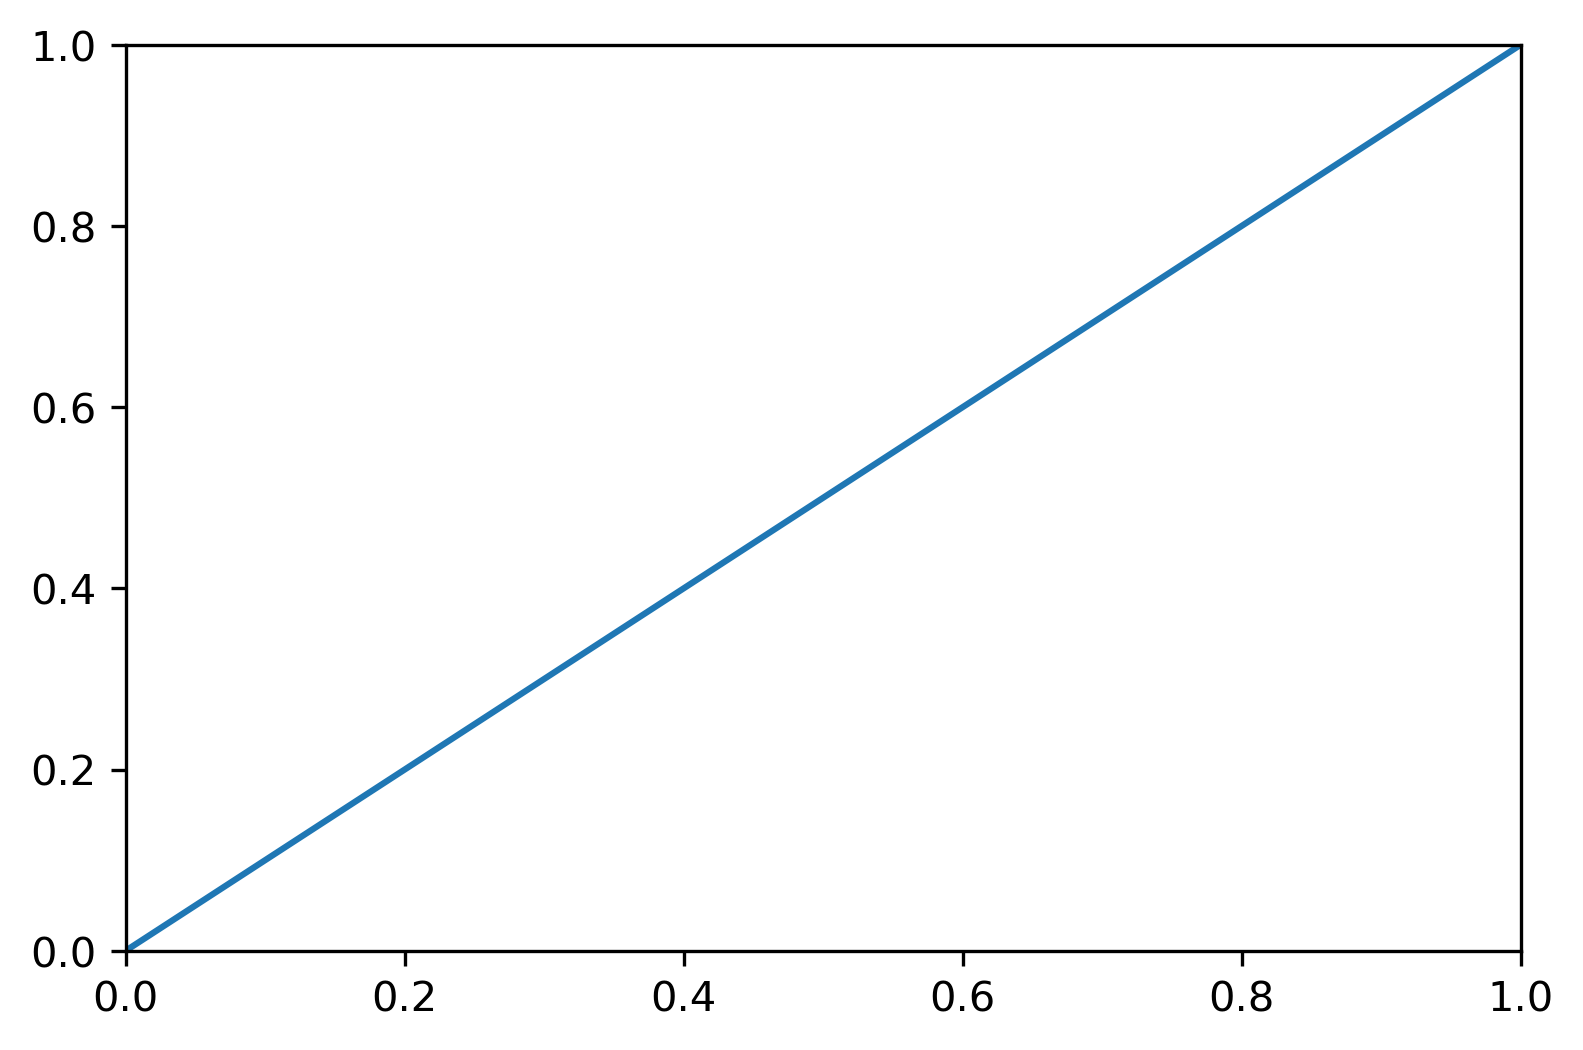